In [244]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
# disable chained assignments
pd.options.mode.chained_assignment = None

In [245]:
endTime = dt.datetime.now()
startTime = dt.datetime(endTime.year - 1, endTime.month, endTime.day)

df = yf.download("BTC-USD", startTime, endTime)

[*********************100%%**********************]  1 of 1 completed


In [246]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,22429.757812,17353192895
2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531,22219.769531,22765452204
2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078,21718.080078,22536575684
2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484,20363.021484,30364664171
2023-03-10,20367.001953,20370.595703,19628.253906,20187.244141,20187.244141,39578257695


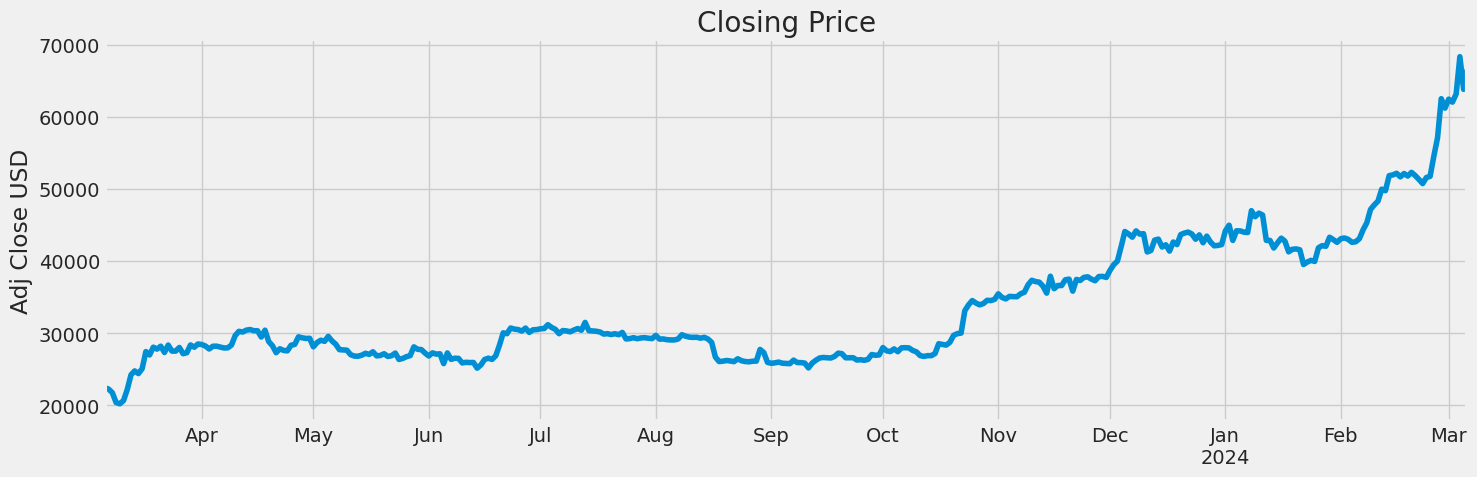

In [247]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(top=1.25, bottom=1.2)

df['Adj Close'].plot()
plt.ylabel('Adj Close USD')
plt.xlabel(None)
plt.title("Closing Price")

plt.tight_layout()

In [248]:
from sklearn.preprocessing import MinMaxScaler

# Create a new dataframe with only the price column
data = df.filter(["Date", "Adj Close"]).reset_index()
data["Adj Close Diff"] = data["Adj Close"] - data["Adj Close"].shift(1)
# Convert the dataframe to a numpy array
dataset = data.filter(["Adj Close"]).values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [249]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(scaled_data) * .95 ))
#Deep learnig
training_deep_len = 60
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(training_deep_len, len(train_data)):
    x_train.append(train_data[i-training_deep_len:i, 0])
    y_train.append(train_data[i, 0])
#Create train array
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [250]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data = (x_valid, y_valid))

Epoch 1/5
231/231 [==============================] - 16s 53ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 2/5
231/231 [==============================] - 11s 49ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/5
231/231 [==============================] - 11s 49ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/5
231/231 [==============================] - 10s 43ms/step - loss: 8.9983e-04 - val_loss: 7.8464e-04
Epoch 5/5
231/231 [==============================] - 11s 49ms/step - loss: 0.0011 - val_loss: 8.3796e-04


<Axes: title={'center': 'Loss curve'}>

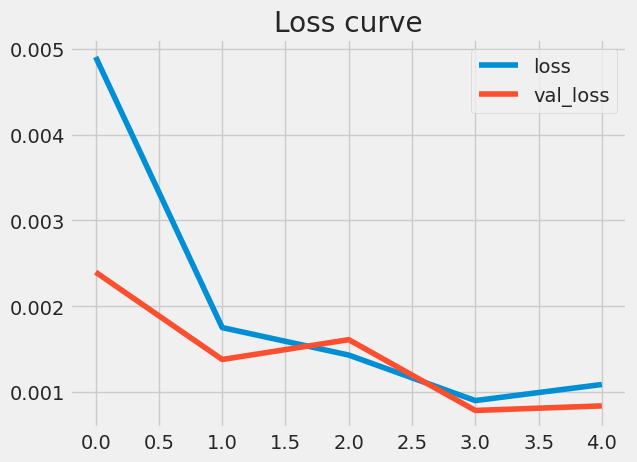

In [251]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

In [252]:
# Create the testing data set
test_data = scaled_data[training_data_len - training_deep_len: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(training_deep_len, len(test_data)):
    x_test.append(test_data[i-training_deep_len:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 [==============================] - 1s 825ms/step


3028.265148212888

Чудовищная валатильность биткоина делает невозможным предсказание его курса,
модель не в состоянии предвидеть выбросы величиной более 10% от пердыдущей цены закрытия.

In [253]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions
rmse_df = test.loc[(np.sqrt(((test["Predictions"] - test["Adj Close"]) ** 2)) > 1)]
rmse_df

,Date,Adj Close,Adj Close Diff,Predictions
349,2024-02-18,52122.546875,459.550781,52534.683594
350,2024-02-19,51779.144531,-343.402344,52617.445312
351,2024-02-20,52284.875000,505.730469,52511.066406
352,2024-02-21,51839.179688,-445.695312,52430.277344
353,2024-02-22,51304.972656,-534.207031,52296.921875
354,2024-02-23,50731.949219,-573.023438,52066.851562
355,2024-02-24,51571.101562,839.152344,51725.488281
356,2024-02-25,51733.238281,162.136719,51572.765625
357,2024-02-26,54522.402344,2789.164062,51600.183594
358,2024-02-27,57085.371094,2562.968750,52308.628906


In [254]:
#future 31 dayes prediction
days = 31

def predict(model, data):
  training_data_len = int(np.ceil(len(data) * .95 ))
  # Create the testing data set
  test_data = data[training_data_len - training_deep_len: , :]
  # Create the data sets x_test and y_test
  x_test = []
  for i in range(training_deep_len, len(test_data)):
      x_test.append(test_data[i-training_deep_len:i, 0])

  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  # Get the models predicted values
  return model.predict(x_test)

future_predictions = scaled_data
for i in range(days):
  future_predictions = np.vstack([future_predictions, predict(model, future_predictions)[-1:,0]])
future_predictions = scaler.inverse_transform(future_predictions)

for i in range(1,days + 1):
  value = future_predictions[len(future_predictions) - (days + 1) + i][0]
  test.loc[len(test)+1] = [dt.datetime.now() + dt.timedelta(days=i), None, None, value]

1/1 [==============================] - 0s 36ms/step


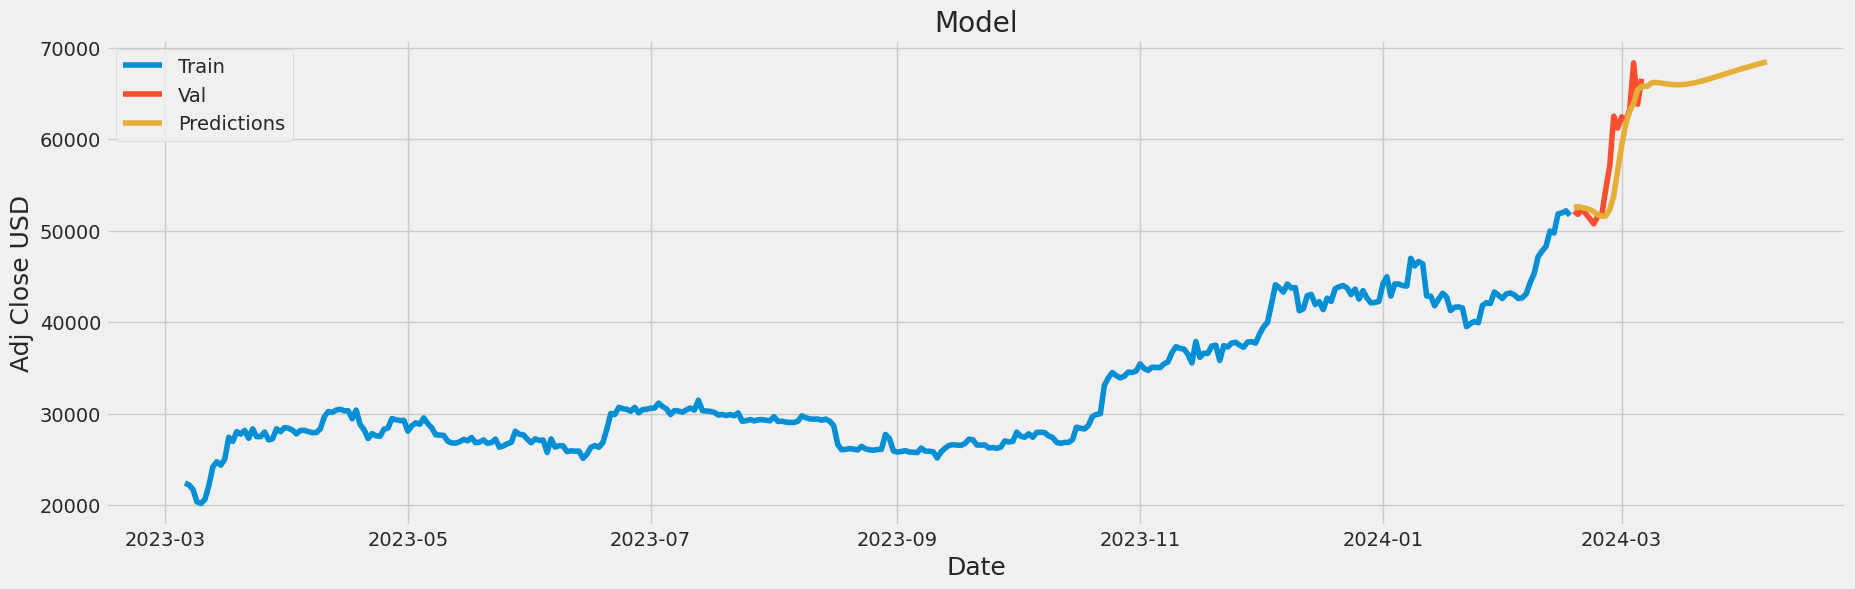

In [255]:
# Visualize the data
plt.figure(figsize=(20,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close USD', fontsize=18)
plt.plot(train["Date"], train['Adj Close'])
plt.plot(test["Date"], test[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()